# Goal

The goal of this colab is to train a CNN on the IBM-NASA dataset for crop clasification.

# Installation

This module is dedicated for the installation of required packages for the usage of this collab.

In [16]:
!pip install segmentation-models-pytorch torch torchvision torchmetrics datasets albumentations rasterio tqdm pandas

# Imports

In [17]:
import os
import rasterio
import copy
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import time
import json


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch import DeepLabV3Plus
from segmentation_models_pytorch.losses import FocalLoss, TverskyLoss
from torch.utils.tensorboard import SummaryWriter


import pandas as pd

from torchmetrics.classification import Accuracy, JaccardIndex
from torchmetrics.segmentation import DiceScore, MeanIoU

from torch.optim.lr_scheduler import PolynomialLR
from torchvision.transforms import ToTensor
from functools import lru_cache
from tqdm import tqdm

# Dataset loading
from datasets import load_dataset

# Google Drive Configuration

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

This block of code will configure all the requried global variables for the project. Some of this variables may have to be changed base on the user so make sure to check them out before executing the program.

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 14

# Trainign
EPOCHS = 50
BATCH_SIZE = 32

# Loading
NUM_WORKERS = 0

# Model params
ENCODER_NAME = "resnet34"
ENCODER_WEIGHTS = None
LEARNING_RATE = 1e-4
DECODER_ATTENTION_TYPE = "scse"
DECODER_USER_NORM = False

# Data directories
DATA_DIR = "/content/drive/MyDrive/Universidad/TFG/Implementations/nasa_ibm/"
UNET_MODEL_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/models/"
UNET_GRAPH_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/"
UNET_METRICS_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/metrics/"

SPLIT_DIR = DATA_DIR + "splited"

TRAINING_IMAGE_DIR = DATA_DIR + "training_chips_merged"
TRAINING_MASK_DIR = DATA_DIR + "training_chips_mask"

VALIDATION_IMAGE_DIR = DATA_DIR + "training_chips_merged"
VALIDATION_MASK_DIR = DATA_DIR + "training_chips_mask"

TEST_IMAGE_DIR = DATA_DIR + "test_chips_merged"
TEST_MASK_DIR = DATA_DIR + "test_chips_mask"

In [8]:
class HFDGeoDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, image_dir, mask_dir, transform=None, is_original_dataset = True ):
        self.dataset = hf_dataset
        self.to_tensor = ToTensor()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.chip_ids = [item['text'] for item in self.dataset]

        self.image_paths = [os.path.join(image_dir, f"{chip_id}_merged.tif")
                           for chip_id in self.chip_ids]
        self.mask_paths = [os.path.join(mask_dir, f"{chip_id}.mask.tif")
                          for chip_id in self.chip_ids]


        self.use_memmap = True

    def __len__(self):
        return len(self.dataset)

    @lru_cache(maxsize=128)  # Cache recently accessed items
    def _load_image(self, image_path):
        """Load image with caching for repeated access."""
        try:
            with rasterio.open(image_path) as src:
                if self.use_memmap:
                    # Try memory-mapped reading when possible
                    image = src.read(out_shape=src.shape, masked=False)
                else:
                    image = src.read()
                return torch.from_numpy(image).type(torch.FloatTensor)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return empty tensor or handle error appropriately
            return torch.zeros((18, 224, 224), dtype=torch.float32)

    @lru_cache(maxsize=128)
    def _load_mask(self, mask_path):
        try:
            with rasterio.open(mask_path) as chip_mask:
                mask = chip_mask.read(1)
                return torch.from_numpy(mask).type(torch.LongTensor)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            return torch.zeros((224, 224), dtype=torch.long)

    def _normalize_per_band(self, image):
        normalized = np.zeros_like(image, dtype=np.float32)

        for i in range(image.shape[0]):
            band = image[i]
            band_min = band.min()
            band_max = band.max()

            if band_max > band_min:
                normalized[i] = ((band - band_min)/(band_max - band_min))
            else:
                normalized[i] = np.zeros_like(band)

        return torch.from_numpy(normalized).float()

    def __getitem__(self, idx):
        chip_id = self.dataset[idx]['text']
        image_path = self.image_paths[idx]
        mask_path  = self.mask_paths[idx]

        image = self._load_image(image_path)
        mask  = self._load_mask(mask_path)

        image = self._normalize_per_band(image)


        return image, mask





def create_datasets(dataset, image_dirs, mask_dirs, transform = None):
    # Create train and validation datasets
    train_dataset = HFDGeoDataset(
        dataset['train'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    val_dataset = HFDGeoDataset(
        dataset['validation'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    return train_dataset, val_dataset

def create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE, ):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=True,
    )

    return train_loader, val_loader


def visualize_random_rgb_sample(dataset, bands=(2, 1, 0), figsize=(10, 5)):
    """
    Picks a random sample and displays specified bands as an RGB composite,
    with per-band min/max normalization for proper visibility.

    Args:
        dataset: your HFDGeoDataset instance
        bands (tuple of int): which bands to use for R, G, B
        figsize (tuple): figure size in inches
    """
    # 1) Pick a random index
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]       # image: Tensor[18, H, W], mask: Tensor[H, W]

    # 2) Select just the three bands and convert to a HxWx3 NumPy array
    img_bands = image[list(bands), ...]            # shape = (3, H, W)
    img_np = img_bands.permute(1, 2, 0).numpy()    # shape = (H, W, 3)

    print( image )

    # 3) Per-band min/max normalization
    for c in range(3):
        band = img_np[..., c]
        mn, mx = band.min(), band.max()
        img_np[..., c] = (band - mn) / (mx - mn + 1e-6)

    # 4) Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img_np)
    ax1.set_title(f"Sample #{idx} RGB (bands {bands})")
    ax1.axis("off")

    ax2.imshow(mask.numpy(), cmap="gray")
    ax2.set_title("Mask")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

<ipython-input-8-657b4d567781>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))


tensor([[[0.1121, 0.1196, 0.1390,  ..., 0.2370, 0.2318, 0.2058],
         [0.1091, 0.1121, 0.1091,  ..., 0.2133, 0.2243, 0.2076],
         [0.1060, 0.1007, 0.0884,  ..., 0.1821, 0.1838, 0.1873],
         ...,
         [0.1755, 0.1588, 0.1469,  ..., 0.1931, 0.1887, 0.1873],
         [0.1799, 0.1807, 0.1662,  ..., 0.2366, 0.2485, 0.2414],
         [0.1592, 0.1631, 0.1429,  ..., 0.2186, 0.2326, 0.2353]],

        [[0.1747, 0.1818, 0.1931,  ..., 0.2988, 0.3063, 0.2641],
         [0.1648, 0.1705, 0.1667,  ..., 0.2724, 0.2969, 0.2799],
         [0.1569, 0.1539, 0.1396,  ..., 0.2558, 0.2565, 0.2648],
         ...,
         [0.1867, 0.1660, 0.1464,  ..., 0.2248, 0.2154, 0.2218],
         [0.1879, 0.1950, 0.1728,  ..., 0.2705, 0.2852, 0.2791],
         [0.1599, 0.1686, 0.1449,  ..., 0.2512, 0.2686, 0.2742]],

        [[0.2357, 0.2409, 0.2507,  ..., 0.3745, 0.3836, 0.3196],
         [0.2107, 0.2201, 0.2142,  ..., 0.3244, 0.3745, 0.3417],
         [0.2029, 0.1928, 0.1707,  ..., 0.3209, 0.3228, 0.

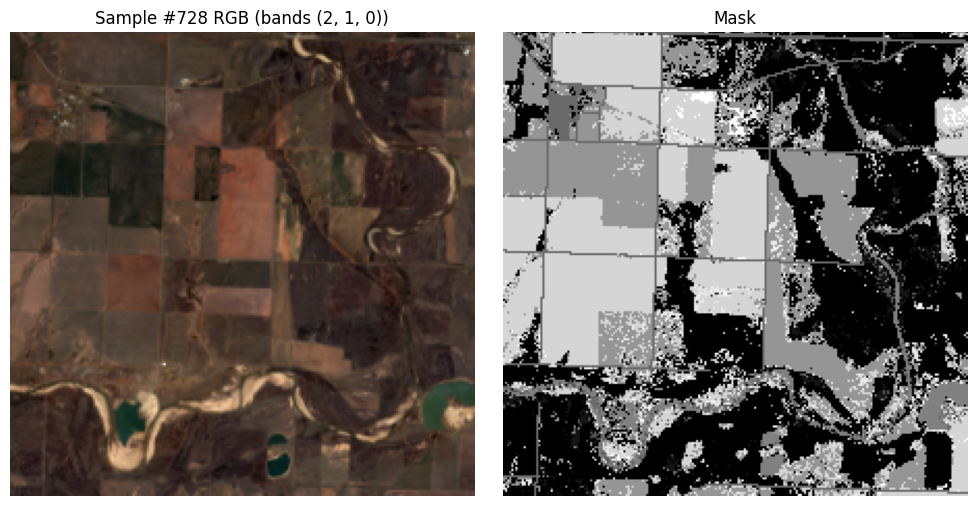

tensor([[[0.3709, 0.3833, 0.4266,  ..., 0.2436, 0.2334, 0.2377],
         [0.3644, 0.3725, 0.3741,  ..., 0.2680, 0.2377, 0.2133],
         [0.3384, 0.3335, 0.3232,  ..., 0.3227, 0.2772, 0.2458],
         ...,
         [0.3714, 0.4055, 0.4348,  ..., 0.3064, 0.3129, 0.3200],
         [0.3736, 0.3898, 0.4201,  ..., 0.3054, 0.3059, 0.3135],
         [0.3687, 0.3904, 0.4099,  ..., 0.2967, 0.2907, 0.3070]],

        [[0.3717, 0.3868, 0.4413,  ..., 0.3038, 0.2933, 0.2878],
         [0.3850, 0.3951, 0.4028,  ..., 0.3130, 0.2681, 0.2397],
         [0.3841, 0.3841, 0.3781,  ..., 0.3621, 0.2993, 0.2686],
         ...,
         [0.3850, 0.4212, 0.4588,  ..., 0.3643, 0.3721, 0.3753],
         [0.3868, 0.4028, 0.4409,  ..., 0.3653, 0.3685, 0.3726],
         [0.3841, 0.4010, 0.4423,  ..., 0.3566, 0.3501, 0.3662]],

        [[0.4701, 0.4827, 0.5349,  ..., 0.3906, 0.3921, 0.4122],
         [0.4903, 0.5040, 0.5140,  ..., 0.4187, 0.3863, 0.3579],
         [0.4964, 0.4986, 0.4910,  ..., 0.5000, 0.4237, 0.

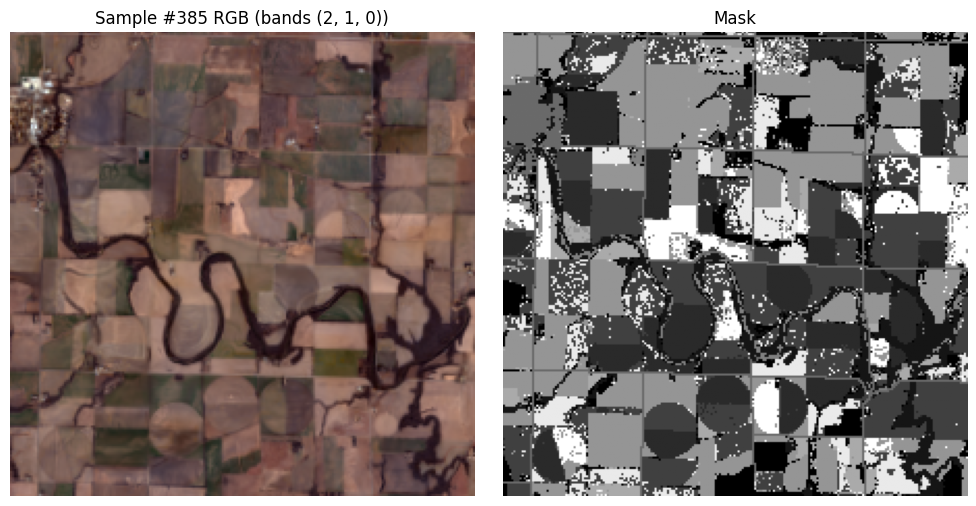

In [9]:
with open(os.path.join(SPLIT_DIR, 'dataset_splits.json')) as f:
    train_val_dataset = json.load(f)



# Create datasets
train_dataset, val_dataset = create_datasets(train_val_dataset, TRAINING_IMAGE_DIR, TRAINING_MASK_DIR)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE)

visualize_random_rgb_sample(train_dataset)
visualize_random_rgb_sample(val_dataset)

In [10]:
model = DeepLabV3Plus(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=18,
    classes=NUM_CLASSES,
    decoder_attention_type=DECODER_ATTENTION_TYPE,
    decoder_use_norm=DECODER_USER_NORM
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

focal_loss = FocalLoss(mode="multiclass", gamma=2.0)
tversky_loss =  TverskyLoss(
    mode='multiclass',        # you have >2 semantic labels
    classes=None,             # include all classes; or e.g. [0,1,2,3] to pick a subset
    log_loss=False,           # use 1 – Tversky; you can switch to True if you prefer –log(Tversky)
    from_logits=True,         # DeepLabV3+ outputs raw logits
    ignore_index=0,           # often “255” is the void/background label in PASCAL VOC–style sets
    gamma=1.0                 # no extra focusing; >1 to emphasize hard/misaligned regions
)
ce_loss = nn.CrossEntropyLoss( ignore_index = 0 );


def criterion(preds, targets):
    """
    preds: raw logits,   shape [B, C, H, W]
    targets: integer labels, shape [B, H, W]
    """
    # ensure integer dtype
    targets = targets.long()

    L_trev = tversky_loss(preds, targets)

    return 1 * L_trev



scheduler = scheduler = PolynomialLR(
    optimizer,
    total_iters=EPOCHS,
    power=2.0,
    last_epoch=-1,
    verbose=True
)

In [11]:
accuracy = Accuracy(task="multiclass", average="macro",  num_classes=NUM_CLASSES).to(DEVICE)
iou = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
dice = DiceScore( num_classes=NUM_CLASSES, average="macro",   input_format="index" ).to(DEVICE)
miou = MeanIoU(num_classes=NUM_CLASSES, include_background= False,  input_format="index"  ).to(DEVICE)

Epoch 1/50:   0%|          | 0/78 [00:00<?, ?it/s]<ipython-input-8-657b4d567781>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))
Epoch 1/50: 100%|██████████| 78/78 [10:59<00:00,  8.45s/it]


[Epoch  0] Loss:  0.8195, Acc:   0.1695, IoU:   0.0845, Dice:  0.0525, mIoU:  0.0363


Epoch 1/50 [Val]: 100%|██████████| 20/20 [01:45<00:00,  5.26s/it]


[Epoch  0] Loss: 0.7635, Acc: 0.2534, IoU: 0.1245, Dice: 0.0664, mIoU: 0.0507


Epoch 2/50: 100%|██████████| 78/78 [05:50<00:00,  4.49s/it]


[Epoch  1] Loss:  0.7250, Acc:   0.2849, IoU:   0.1643, Dice:  0.0859, mIoU:  0.0672


Epoch 2/50 [Val]: 100%|██████████| 20/20 [01:17<00:00,  3.90s/it]


[Epoch  1] Loss: 0.6991, Acc: 0.3173, IoU: 0.1786, Dice: 0.0951, mIoU: 0.0755


Epoch 3/50: 100%|██████████| 78/78 [05:25<00:00,  4.17s/it]


[Epoch  2] Loss:  0.6692, Acc:   0.3287, IoU:   0.1981, Dice:  0.1089, mIoU:  0.0872


Epoch 3/50 [Val]: 100%|██████████| 20/20 [01:30<00:00,  4.53s/it]


[Epoch  2] Loss: 0.6815, Acc: 0.3081, IoU: 0.1902, Dice: 0.1108, mIoU: 0.0898


Epoch 4/50: 100%|██████████| 78/78 [05:22<00:00,  4.14s/it]


[Epoch  3] Loss:  0.6393, Acc:   0.3493, IoU:   0.2163, Dice:  0.1231, mIoU:  0.0995


Epoch 4/50 [Val]: 100%|██████████| 20/20 [01:14<00:00,  3.74s/it]


[Epoch  3] Loss: 0.6685, Acc: 0.3507, IoU: 0.1867, Dice: 0.1101, mIoU: 0.0884


Epoch 5/50: 100%|██████████| 78/78 [05:24<00:00,  4.16s/it]


[Epoch  4] Loss:  0.6174, Acc:   0.3687, IoU:   0.2330, Dice:  0.1357, mIoU:  0.1097


Epoch 5/50 [Val]: 100%|██████████| 20/20 [01:29<00:00,  4.47s/it]


[Epoch  4] Loss: 0.6074, Acc: 0.3768, IoU: 0.2413, Dice: 0.1412, mIoU: 0.1145


Epoch 6/50: 100%|██████████| 78/78 [05:05<00:00,  3.91s/it]


[Epoch  5] Loss:  0.5957, Acc:   0.3911, IoU:   0.2507, Dice:  0.1477, mIoU:  0.1198


Epoch 6/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.41s/it]


[Epoch  5] Loss: 0.6016, Acc: 0.3835, IoU: 0.2470, Dice: 0.1460, mIoU: 0.1194


Epoch 7/50: 100%|██████████| 78/78 [05:34<00:00,  4.28s/it]


[Epoch  6] Loss:  0.5860, Acc:   0.3999, IoU:   0.2574, Dice:  0.1559, mIoU:  0.1267


Epoch 7/50 [Val]: 100%|██████████| 20/20 [01:02<00:00,  3.14s/it]


[Epoch  6] Loss: 0.5930, Acc: 0.4159, IoU: 0.2556, Dice: 0.1525, mIoU: 0.1250


Epoch 8/50: 100%|██████████| 78/78 [05:30<00:00,  4.23s/it]


[Epoch  7] Loss:  0.5687, Acc:   0.4146, IoU:   0.2712, Dice:  0.1662, mIoU:  0.1357


Epoch 8/50 [Val]: 100%|██████████| 20/20 [01:25<00:00,  4.30s/it]


[Epoch  7] Loss: 0.6068, Acc: 0.3764, IoU: 0.2418, Dice: 0.1553, mIoU: 0.1263


Epoch 9/50: 100%|██████████| 78/78 [05:07<00:00,  3.94s/it]


[Epoch  8] Loss:  0.5602, Acc:   0.4198, IoU:   0.2752, Dice:  0.1706, mIoU:  0.1394


Epoch 9/50 [Val]: 100%|██████████| 20/20 [01:26<00:00,  4.32s/it]


[Epoch  8] Loss: 0.5740, Acc: 0.4187, IoU: 0.2667, Dice: 0.1714, mIoU: 0.1402


Epoch 10/50: 100%|██████████| 78/78 [05:08<00:00,  3.95s/it]


[Epoch  9] Loss:  0.5490, Acc:   0.4323, IoU:   0.2863, Dice:  0.1785, mIoU:  0.1467


Epoch 10/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.41s/it]


[Epoch  9] Loss: 0.5638, Acc: 0.4198, IoU: 0.2722, Dice: 0.1743, mIoU: 0.1432


Epoch 11/50: 100%|██████████| 78/78 [05:21<00:00,  4.12s/it]


[Epoch 10] Loss:  0.5399, Acc:   0.4398, IoU:   0.2928, Dice:  0.1837, mIoU:  0.1515


Epoch 11/50 [Val]: 100%|██████████| 20/20 [01:19<00:00,  3.97s/it]


[Epoch 10] Loss: 0.5677, Acc: 0.4326, IoU: 0.2726, Dice: 0.1757, mIoU: 0.1438


Epoch 12/50: 100%|██████████| 78/78 [05:40<00:00,  4.37s/it]


[Epoch 11] Loss:  0.5366, Acc:   0.4449, IoU:   0.2963, Dice:  0.1868, mIoU:  0.1543


Epoch 12/50 [Val]: 100%|██████████| 20/20 [01:32<00:00,  4.60s/it]


[Epoch 11] Loss: 0.5683, Acc: 0.4274, IoU: 0.2743, Dice: 0.1717, mIoU: 0.1399


Epoch 13/50: 100%|██████████| 78/78 [05:08<00:00,  3.96s/it]


[Epoch 12] Loss:  0.5295, Acc:   0.4493, IoU:   0.3004, Dice:  0.1907, mIoU:  0.1578


Epoch 13/50 [Val]: 100%|██████████| 20/20 [01:26<00:00,  4.34s/it]


[Epoch 12] Loss: 0.5575, Acc: 0.4056, IoU: 0.2798, Dice: 0.1791, mIoU: 0.1483


Epoch 14/50: 100%|██████████| 78/78 [04:55<00:00,  3.79s/it]


[Epoch 13] Loss:  0.5210, Acc:   0.4555, IoU:   0.3072, Dice:  0.1945, mIoU:  0.1613


Epoch 14/50 [Val]: 100%|██████████| 20/20 [01:25<00:00,  4.27s/it]


[Epoch 13] Loss: 0.5638, Acc: 0.4124, IoU: 0.2737, Dice: 0.1737, mIoU: 0.1423


Epoch 15/50: 100%|██████████| 78/78 [04:56<00:00,  3.80s/it]


[Epoch 14] Loss:  0.5156, Acc:   0.4622, IoU:   0.3133, Dice:  0.1982, mIoU:  0.1649


Epoch 15/50 [Val]: 100%|██████████| 20/20 [01:26<00:00,  4.35s/it]


[Epoch 14] Loss: 0.5408, Acc: 0.4459, IoU: 0.2882, Dice: 0.1879, mIoU: 0.1555


Epoch 16/50: 100%|██████████| 78/78 [04:53<00:00,  3.77s/it]


[Epoch 15] Loss:  0.5071, Acc:   0.4696, IoU:   0.3191, Dice:  0.2019, mIoU:  0.1683


Epoch 16/50 [Val]: 100%|██████████| 20/20 [01:26<00:00,  4.32s/it]


[Epoch 15] Loss: 0.5437, Acc: 0.4256, IoU: 0.2926, Dice: 0.1875, mIoU: 0.1559


Epoch 17/50: 100%|██████████| 78/78 [05:21<00:00,  4.13s/it]


[Epoch 16] Loss:  0.5016, Acc:   0.4738, IoU:   0.3226, Dice:  0.2040, mIoU:  0.1706


Epoch 17/50 [Val]: 100%|██████████| 20/20 [00:58<00:00,  2.93s/it]


[Epoch 16] Loss: 0.5440, Acc: 0.4395, IoU: 0.2915, Dice: 0.1915, mIoU: 0.1592


Epoch 18/50: 100%|██████████| 78/78 [05:22<00:00,  4.14s/it]


[Epoch 17] Loss:  0.5023, Acc:   0.4742, IoU:   0.3242, Dice:  0.2057, mIoU:  0.1719


Epoch 18/50 [Val]: 100%|██████████| 20/20 [00:58<00:00,  2.93s/it]


[Epoch 17] Loss: 0.5299, Acc: 0.4394, IoU: 0.3026, Dice: 0.1963, mIoU: 0.1645


Epoch 19/50: 100%|██████████| 78/78 [05:21<00:00,  4.12s/it]


[Epoch 18] Loss:  0.4886, Acc:   0.4865, IoU:   0.3349, Dice:  0.2106, mIoU:  0.1768


Epoch 19/50 [Val]: 100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


[Epoch 18] Loss: 0.5370, Acc: 0.4325, IoU: 0.2991, Dice: 0.1994, mIoU: 0.1664


Epoch 20/50: 100%|██████████| 78/78 [05:25<00:00,  4.18s/it]


[Epoch 19] Loss:  0.4897, Acc:   0.4869, IoU:   0.3349, Dice:  0.2122, mIoU:  0.1781


Epoch 20/50 [Val]: 100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


[Epoch 19] Loss: 0.5268, Acc: 0.4504, IoU: 0.3006, Dice: 0.1950, mIoU: 0.1612


Epoch 21/50: 100%|██████████| 78/78 [05:25<00:00,  4.18s/it]


[Epoch 20] Loss:  0.4866, Acc:   0.4874, IoU:   0.3364, Dice:  0.2132, mIoU:  0.1788


Epoch 21/50 [Val]: 100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


[Epoch 20] Loss: 0.5461, Acc: 0.4146, IoU: 0.2858, Dice: 0.1858, mIoU: 0.1535


Epoch 22/50: 100%|██████████| 78/78 [05:22<00:00,  4.14s/it]


[Epoch 21] Loss:  0.4774, Acc:   0.4987, IoU:   0.3462, Dice:  0.2173, mIoU:  0.1834


Epoch 22/50 [Val]: 100%|██████████| 20/20 [00:59<00:00,  2.95s/it]


[Epoch 21] Loss: 0.5271, Acc: 0.4393, IoU: 0.3073, Dice: 0.2040, mIoU: 0.1708


Epoch 23/50: 100%|██████████| 78/78 [05:24<00:00,  4.16s/it]


[Epoch 22] Loss:  0.4746, Acc:   0.5008, IoU:   0.3487, Dice:  0.2187, mIoU:  0.1844


Epoch 23/50 [Val]: 100%|██████████| 20/20 [00:58<00:00,  2.90s/it]


[Epoch 22] Loss: 0.5261, Acc: 0.4615, IoU: 0.3008, Dice: 0.1985, mIoU: 0.1643


Epoch 24/50: 100%|██████████| 78/78 [05:27<00:00,  4.20s/it]


[Epoch 23] Loss:  0.4717, Acc:   0.5050, IoU:   0.3528, Dice:  0.2206, mIoU:  0.1863


Epoch 24/50 [Val]: 100%|██████████| 20/20 [00:58<00:00,  2.94s/it]


[Epoch 23] Loss: 0.5178, Acc: 0.4512, IoU: 0.3071, Dice: 0.2039, mIoU: 0.1701


Epoch 25/50: 100%|██████████| 78/78 [05:27<00:00,  4.19s/it]


[Epoch 24] Loss:  0.4640, Acc:   0.5139, IoU:   0.3603, Dice:  0.2251, mIoU:  0.1905


Epoch 25/50 [Val]: 100%|██████████| 20/20 [00:58<00:00,  2.92s/it]


[Epoch 24] Loss: 0.5438, Acc: 0.4246, IoU: 0.2845, Dice: 0.1973, mIoU: 0.1641


Epoch 26/50: 100%|██████████| 78/78 [05:26<00:00,  4.18s/it]


[Epoch 25] Loss:  0.4626, Acc:   0.5117, IoU:   0.3585, Dice:  0.2245, mIoU:  0.1893


Epoch 26/50 [Val]: 100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


[Epoch 25] Loss: 0.5362, Acc: 0.4273, IoU: 0.2929, Dice: 0.1997, mIoU: 0.1648


Epoch 27/50: 100%|██████████| 78/78 [05:23<00:00,  4.15s/it]


[Epoch 26] Loss:  0.4534, Acc:   0.5212, IoU:   0.3669, Dice:  0.2286, mIoU:  0.1939


Epoch 27/50 [Val]: 100%|██████████| 20/20 [01:26<00:00,  4.32s/it]


[Epoch 26] Loss: 0.5295, Acc: 0.4413, IoU: 0.2965, Dice: 0.2022, mIoU: 0.1690


Epoch 28/50: 100%|██████████| 78/78 [04:53<00:00,  3.76s/it]


[Epoch 27] Loss:  0.4651, Acc:   0.5119, IoU:   0.3575, Dice:  0.2250, mIoU:  0.1897


Epoch 28/50 [Val]: 100%|██████████| 20/20 [01:24<00:00,  4.24s/it]


[Epoch 27] Loss: 0.5396, Acc: 0.4238, IoU: 0.2939, Dice: 0.2006, mIoU: 0.1671


Epoch 29/50: 100%|██████████| 78/78 [04:52<00:00,  3.75s/it]


[Epoch 28] Loss:  0.4514, Acc:   0.5241, IoU:   0.3696, Dice:  0.2305, mIoU:  0.1956


Epoch 29/50 [Val]: 100%|██████████| 20/20 [01:24<00:00,  4.23s/it]


[Epoch 28] Loss: 0.5372, Acc: 0.4275, IoU: 0.2933, Dice: 0.2002, mIoU: 0.1666


Epoch 30/50: 100%|██████████| 78/78 [04:53<00:00,  3.76s/it]


[Epoch 29] Loss:  0.4454, Acc:   0.5273, IoU:   0.3738, Dice:  0.2329, mIoU:  0.1976


Epoch 30/50 [Val]: 100%|██████████| 20/20 [01:24<00:00,  4.23s/it]


[Epoch 29] Loss: 0.5307, Acc: 0.4393, IoU: 0.3037, Dice: 0.2043, mIoU: 0.1693


Epoch 31/50: 100%|██████████| 78/78 [04:53<00:00,  3.76s/it]


[Epoch 30] Loss:  0.4457, Acc:   0.5328, IoU:   0.3777, Dice:  0.2344, mIoU:  0.1995


Epoch 31/50 [Val]: 100%|██████████| 20/20 [01:25<00:00,  4.26s/it]


[Epoch 30] Loss: 0.5243, Acc: 0.4437, IoU: 0.3085, Dice: 0.2108, mIoU: 0.1772


Epoch 32/50: 100%|██████████| 78/78 [04:57<00:00,  3.82s/it]


[Epoch 31] Loss:  0.4360, Acc:   0.5391, IoU:   0.3846, Dice:  0.2380, mIoU:  0.2034


Epoch 32/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.41s/it]


[Epoch 31] Loss: 0.5227, Acc: 0.4381, IoU: 0.3070, Dice: 0.2077, mIoU: 0.1743


Epoch 33/50: 100%|██████████| 78/78 [04:54<00:00,  3.78s/it]


[Epoch 32] Loss:  0.4287, Acc:   0.5468, IoU:   0.3917, Dice:  0.2415, mIoU:  0.2069


Epoch 33/50 [Val]: 100%|██████████| 20/20 [01:25<00:00,  4.27s/it]


[Epoch 32] Loss: 0.5154, Acc: 0.4465, IoU: 0.3124, Dice: 0.2133, mIoU: 0.1796


Epoch 34/50: 100%|██████████| 78/78 [05:21<00:00,  4.12s/it]


[Epoch 33] Loss:  0.4270, Acc:   0.5512, IoU:   0.3955, Dice:  0.2433, mIoU:  0.2087


Epoch 34/50 [Val]: 100%|██████████| 20/20 [00:59<00:00,  2.98s/it]


[Epoch 33] Loss: 0.5142, Acc: 0.4564, IoU: 0.3149, Dice: 0.2153, mIoU: 0.1777


Epoch 35/50: 100%|██████████| 78/78 [05:23<00:00,  4.15s/it]


[Epoch 34] Loss:  0.4262, Acc:   0.5531, IoU:   0.3973, Dice:  0.2453, mIoU:  0.2104


Epoch 35/50 [Val]: 100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


[Epoch 34] Loss: 0.5080, Acc: 0.4617, IoU: 0.3191, Dice: 0.2157, mIoU: 0.1808


Epoch 36/50: 100%|██████████| 78/78 [05:23<00:00,  4.15s/it]


[Epoch 35] Loss:  0.4202, Acc:   0.5580, IoU:   0.4023, Dice:  0.2476, mIoU:  0.2127


Epoch 36/50 [Val]: 100%|██████████| 20/20 [00:58<00:00,  2.92s/it]


[Epoch 35] Loss: 0.5203, Acc: 0.4498, IoU: 0.3091, Dice: 0.2099, mIoU: 0.1726


Epoch 37/50: 100%|██████████| 78/78 [05:27<00:00,  4.20s/it]


[Epoch 36] Loss:  0.4152, Acc:   0.5616, IoU:   0.4062, Dice:  0.2496, mIoU:  0.2147


Epoch 37/50 [Val]: 100%|██████████| 20/20 [00:57<00:00,  2.90s/it]


[Epoch 36] Loss: 0.5202, Acc: 0.4446, IoU: 0.3130, Dice: 0.2147, mIoU: 0.1798


Epoch 38/50: 100%|██████████| 78/78 [05:24<00:00,  4.16s/it]


[Epoch 37] Loss:  0.4104, Acc:   0.5652, IoU:   0.4103, Dice:  0.2520, mIoU:  0.2171


Epoch 38/50 [Val]: 100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


[Epoch 37] Loss: 0.5108, Acc: 0.4604, IoU: 0.3153, Dice: 0.2179, mIoU: 0.1811


Epoch 39/50: 100%|██████████| 78/78 [05:24<00:00,  4.16s/it]


[Epoch 38] Loss:  0.4084, Acc:   0.5662, IoU:   0.4114, Dice:  0.2524, mIoU:  0.2174


Epoch 39/50 [Val]: 100%|██████████| 20/20 [01:25<00:00,  4.28s/it]


[Epoch 38] Loss: 0.5155, Acc: 0.4413, IoU: 0.3062, Dice: 0.2105, mIoU: 0.1742


Epoch 40/50: 100%|██████████| 78/78 [04:54<00:00,  3.77s/it]


[Epoch 39] Loss:  0.4030, Acc:   0.5726, IoU:   0.4176, Dice:  0.2556, mIoU:  0.2210


Epoch 40/50 [Val]: 100%|██████████| 20/20 [01:27<00:00,  4.38s/it]


[Epoch 39] Loss: 0.5151, Acc: 0.4649, IoU: 0.3153, Dice: 0.2178, mIoU: 0.1807


Epoch 41/50: 100%|██████████| 78/78 [04:56<00:00,  3.80s/it]


[Epoch 40] Loss:  0.4035, Acc:   0.5712, IoU:   0.4170, Dice:  0.2558, mIoU:  0.2208


Epoch 41/50 [Val]: 100%|██████████| 20/20 [01:26<00:00,  4.31s/it]


[Epoch 40] Loss: 0.4996, Acc: 0.4697, IoU: 0.3233, Dice: 0.2211, mIoU: 0.1855


Epoch 42/50: 100%|██████████| 78/78 [04:52<00:00,  3.74s/it]


[Epoch 41] Loss:  0.3998, Acc:   0.5748, IoU:   0.4212, Dice:  0.2579, mIoU:  0.2235


Epoch 42/50 [Val]: 100%|██████████| 20/20 [01:24<00:00,  4.21s/it]


[Epoch 41] Loss: 0.5205, Acc: 0.4466, IoU: 0.3071, Dice: 0.2143, mIoU: 0.1771


Epoch 43/50: 100%|██████████| 78/78 [04:51<00:00,  3.74s/it]


[Epoch 42] Loss:  0.4018, Acc:   0.5729, IoU:   0.4193, Dice:  0.2572, mIoU:  0.2219


Epoch 43/50 [Val]: 100%|██████████| 20/20 [01:25<00:00,  4.25s/it]


[Epoch 42] Loss: 0.5192, Acc: 0.4432, IoU: 0.3056, Dice: 0.2155, mIoU: 0.1798


Epoch 44/50: 100%|██████████| 78/78 [04:52<00:00,  3.75s/it]


[Epoch 43] Loss:  0.3954, Acc:   0.5770, IoU:   0.4232, Dice:  0.2593, mIoU:  0.2243


Epoch 44/50 [Val]: 100%|██████████| 20/20 [01:26<00:00,  4.34s/it]


[Epoch 43] Loss: 0.5201, Acc: 0.4381, IoU: 0.3053, Dice: 0.2086, mIoU: 0.1747


Epoch 45/50: 100%|██████████| 78/78 [04:53<00:00,  3.77s/it]


[Epoch 44] Loss:  0.3948, Acc:   0.5827, IoU:   0.4287, Dice:  0.2621, mIoU:  0.2274


Epoch 45/50 [Val]: 100%|██████████| 20/20 [01:26<00:00,  4.32s/it]


[Epoch 44] Loss: 0.5030, Acc: 0.4690, IoU: 0.3215, Dice: 0.2186, mIoU: 0.1824


Epoch 46/50: 100%|██████████| 78/78 [04:54<00:00,  3.78s/it]


[Epoch 45] Loss:  0.3912, Acc:   0.5843, IoU:   0.4309, Dice:  0.2630, mIoU:  0.2286


Epoch 46/50 [Val]: 100%|██████████| 20/20 [01:25<00:00,  4.26s/it]


[Epoch 45] Loss: 0.5055, Acc: 0.4509, IoU: 0.3161, Dice: 0.2201, mIoU: 0.1840


Epoch 47/50: 100%|██████████| 78/78 [04:52<00:00,  3.74s/it]


[Epoch 46] Loss:  0.3856, Acc:   0.5898, IoU:   0.4366, Dice:  0.2664, mIoU:  0.2320


Epoch 47/50 [Val]: 100%|██████████| 20/20 [01:26<00:00,  4.32s/it]


[Epoch 46] Loss: 0.5099, Acc: 0.4404, IoU: 0.3135, Dice: 0.2148, mIoU: 0.1799


Epoch 48/50: 100%|██████████| 78/78 [04:51<00:00,  3.74s/it]


[Epoch 47] Loss:  0.3867, Acc:   0.5881, IoU:   0.4350, Dice:  0.2663, mIoU:  0.2318


Epoch 48/50 [Val]: 100%|██████████| 20/20 [01:24<00:00,  4.23s/it]


[Epoch 47] Loss: 0.5257, Acc: 0.4441, IoU: 0.3072, Dice: 0.2138, mIoU: 0.1759


Epoch 49/50: 100%|██████████| 78/78 [05:05<00:00,  3.92s/it]


[Epoch 48] Loss:  0.3861, Acc:   0.5886, IoU:   0.4358, Dice:  0.2665, mIoU:  0.2319


Epoch 49/50 [Val]: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


[Epoch 48] Loss: 0.5033, Acc: 0.4613, IoU: 0.3221, Dice: 0.2193, mIoU: 0.1832


Epoch 50/50: 100%|██████████| 78/78 [04:56<00:00,  3.80s/it]


[Epoch 49] Loss:  0.3762, Acc:   0.5962, IoU:   0.4443, Dice:  0.2705, mIoU:  0.2369


Epoch 50/50 [Val]: 100%|██████████| 20/20 [01:24<00:00,  4.24s/it]

[Epoch 49] Loss: 0.5112, Acc: 0.4429, IoU: 0.3150, Dice: 0.2200, mIoU: 0.1851


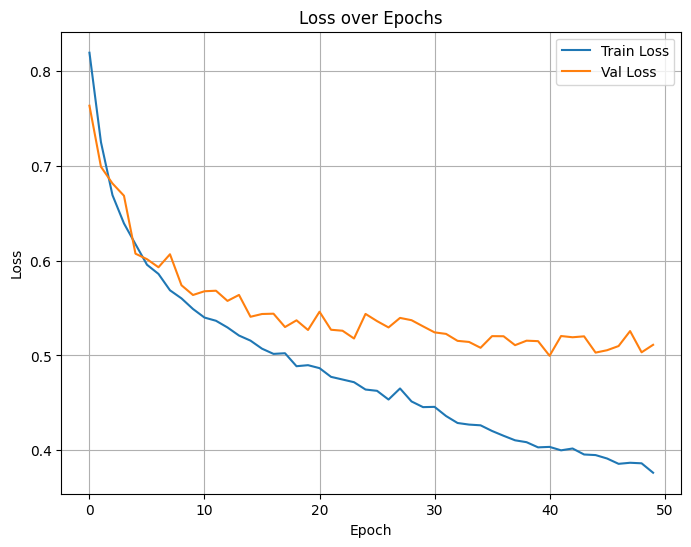

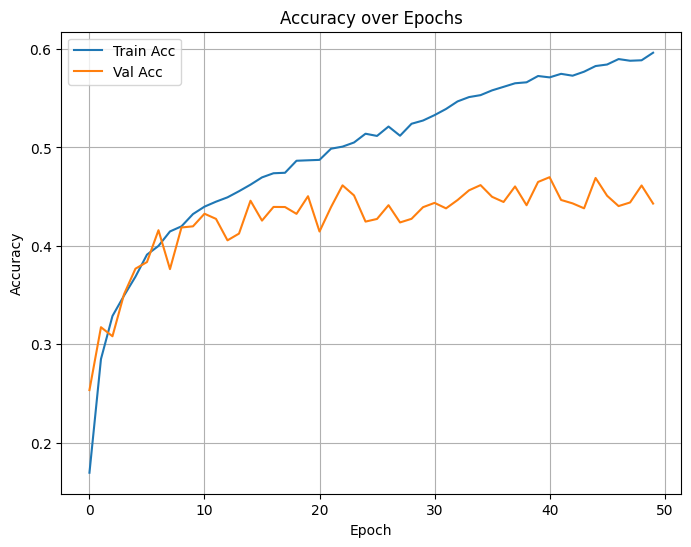

In [12]:


writer = SummaryWriter(log_dir="runs/experiment1")

labels = {
      0: "No Data",
      1: "Natural Vegetation",
      2: "Forest",
      3: "Corn",
      4: "Soybeans",
      5: "Wetlands",
      6: "Developed Barren",
      7: "Open Water",
      8: "Winter Wheat",
      9: "Alfalfa",
      10: "Fallow Idle Cropland",
      11: "Cotton",
      12: "Sorghum",
      13: "Other"
  }

train_losses, train_accs, train_ious, train_mious, train_dices = [], [], [], [], []
val_losses,   val_accs,   val_ious,   val_mious,  val_dices = [], [], [], [], []
best_val_acc = 0.0
best_epoch     = 0
best_model_wts = None

for epoch in range(EPOCHS):
    model.train()
    train_loss_sum = train_acc_sum = train_iou_sum = train_dice_sum = train_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    ### ——— TRAIN ———
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)

        accuracy.update(preds, masks)
        iou      .update(preds, masks)
        dice     .update(preds, masks)
        miou     .update(preds, masks)

        train_loss_sum  += loss.item()

    # Average metrics
    train_losses.append(train_loss_sum / len(train_loader))
    train_accs  .append(accuracy.compute().item())
    train_ious  .append(iou.compute().item())
    train_dices .append(dice.compute().item())
    train_mious .append(miou.compute().item())

    writer.add_scalar('Loss/train', train_losses[-1], epoch)
    writer.add_scalar('Accuracy/train', train_accs[-1], epoch)
    writer.add_scalar('IoU/train', train_ious[-1], epoch)
    writer.add_scalar('Dice/train', train_dices[-1], epoch)
    writer.add_scalar('mIoU/train', train_mious[-1], epoch)


    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss:  {train_losses[-1]:.4f}, "
        f"Acc:   {train_accs[-1]:.4f}, "
        f"IoU:   {train_ious[-1]:.4f}, "
        f"Dice:  {train_dices[-1]:.4f}, "
        f"mIoU:  {train_mious[-1]:.4f}"
    )

    ### ——— VALIDATION ———
    model.eval()
    val_loss_sum = val_acc_sum = val_iou_sum = val_dice_sum = val_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, masks)
            iou      .update(preds, masks)
            dice     .update(preds, masks)
            miou     .update(preds, masks)

            val_loss_sum  += loss.item()

    # Average metrics
    val_acc = accuracy.compute().item()
    val_losses.append(val_loss_sum / len(val_loader))
    val_accs  .append(val_acc)
    val_ious  .append(iou.compute().item())
    val_dices .append(dice.compute().item())
    val_mious .append(miou.compute().item())

    # Log to TensorBoard
    writer.add_scalar('Loss/val', val_losses[-1], epoch)
    writer.add_scalar('Accuracy/val', val_accs[-1], epoch)
    writer.add_scalar('IoU/val', val_ious[-1], epoch)
    writer.add_scalar('Dice/val', val_dices[-1], epoch)
    writer.add_scalar('mIoU/val', val_mious[-1], epoch)

    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss: {val_losses[-1]:.4f}, "
        f"Acc: {val_accs[-1]:.4f}, "
        f"IoU: {val_ious[-1]:.4f}, "
        f"Dice: {val_dices[-1]:.4f}, "
        f"mIoU: {val_mious[-1]:.4f}"
    )

    # Scheduler step on validation loss
    scheduler.step(val_losses[-1])

    if val_acc > best_val_acc:
        best_val_acc   = val_acc
        best_epoch     = epoch + 1
        best_model_wts = copy.deepcopy(model.state_dict())


model.load_state_dict(best_model_wts)

# After training, plot metrics separately
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_accs,  label='Train Acc')
plt.plot(val_accs,    label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Close TensorBoard writer
writer.close()


Saved Loss plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_loss_20250516-234840_normalized_polynomial_trevesky_shuffle.png


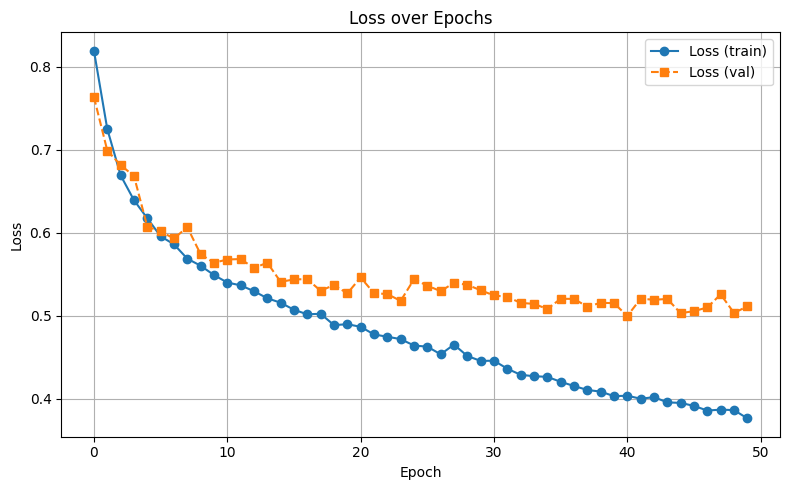

Saved Accuracy plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_accuracy_20250516-234840_normalized_polynomial_trevesky_shuffle.png


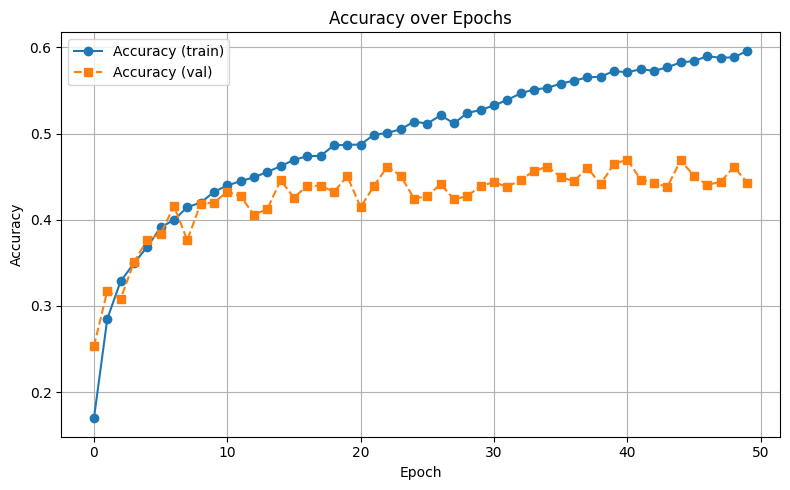

Saved Iou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_iou_20250516-234840_normalized_polynomial_trevesky_shuffle.png


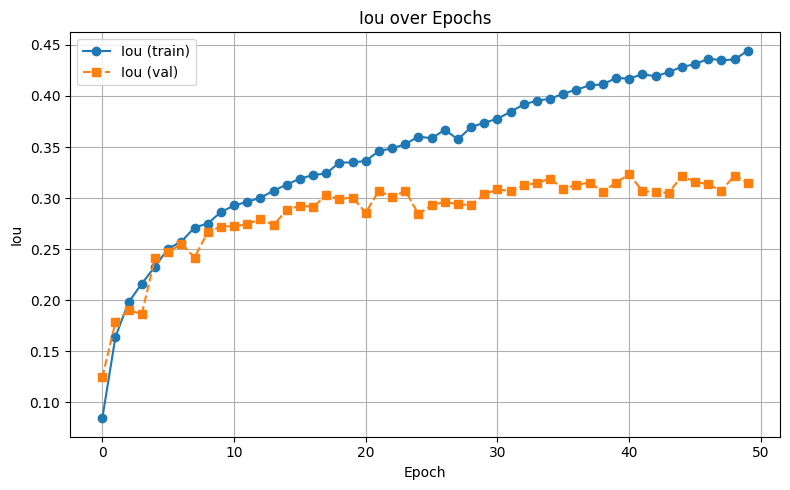

Saved Dice plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_dice_20250516-234840_normalized_polynomial_trevesky_shuffle.png


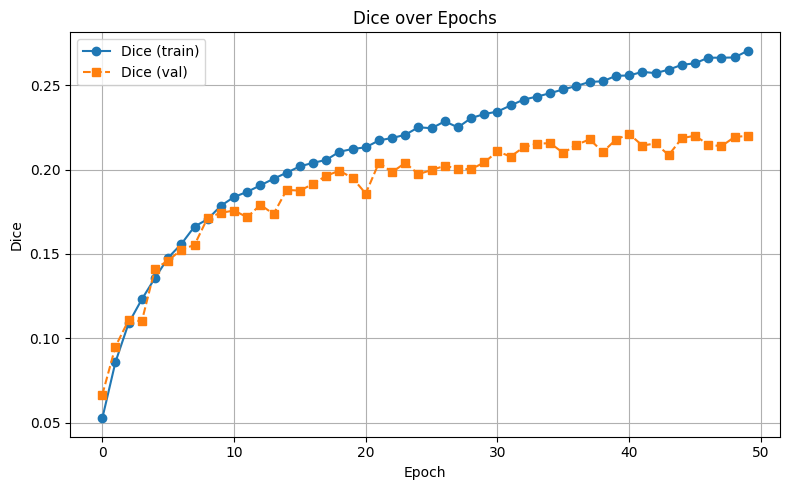

Saved Miou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_miou_20250516-234840_normalized_polynomial_trevesky_shuffle.png


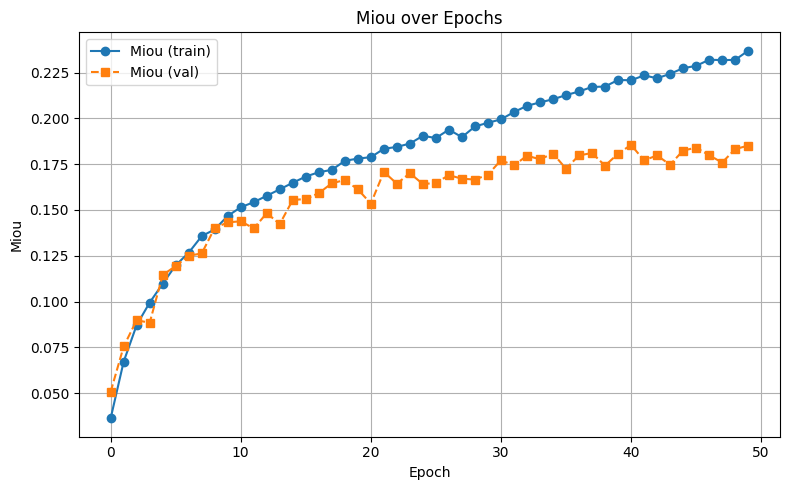

In [13]:
timestamp = time.strftime("%Y%m%d-%H%M%S")

all_metrics = {
    'loss':  (train_losses, val_losses),
    'accuracy': (train_accs, val_accs),
    'iou':    (train_ious, val_ious),
    'dice':   (train_dices, val_dices),
    'miou':   (train_mious, val_mious),
}

for metric_name, (train_vals, val_vals) in all_metrics.items():
    plt.figure(figsize=(8, 5))
    plt.plot(train_vals, marker='o', linestyle='-', label=f'{metric_name.title()} (train)')
    plt.plot(val_vals,   marker='s', linestyle='--', label=f'{metric_name.title()} (val)')
    plt.title(f'{metric_name.title()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # build a descriptive filename
    filename = (
        f"deeplabv3+_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
        f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_"
        f"{metric_name}_{timestamp}_normalized_polynomial_trevesky_shuffle.png"
    )
    save_path = os.path.join(UNET_GRAPH_FOLDER, filename)

    # save and show
    plt.savefig(save_path, dpi=300)
    print(f"Saved {metric_name.title()} plot to: {save_path}")
    plt.show()

In [14]:

os.makedirs(UNET_MODEL_FOLDER, exist_ok=True)

model_filename = (
    f"deeplabv3+_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_"
    f"lr{LEARNING_RATE:.0e}_normalized_polynomial_trevesky_shuffle.pth"
)

model_path = os.path.join(UNET_MODEL_FOLDER, model_filename)


torch.save(model.state_dict(), model_path)
print(f"Saved model checkpoint to: {model_path}")


Saved model checkpoint to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/models/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_normalized_polynomial_trevesky_shuffle.pth


In [15]:
os.makedirs(UNET_METRICS_FOLDER, exist_ok=True)

# Build a DataFrame with both train & val metrics
metrics_df = pd.DataFrame({
    'Epoch':        list(range(1, len(train_losses) + 1)),
    'train_Loss':   train_losses,
    'train_Acc':    train_accs,
    'train_IoU':    train_ious,
    'train_Dice':   train_dices,
    'train_mIoU':   train_mious,
    'val_Loss':     val_losses,
    'val_Acc':      val_accs,
    'val_IoU':      val_ious,
    'val_Dice':     val_dices,
    'val_mIoU':     val_mious,
})

# Descriptive filename using your hyper-params
csv_filename = (
    f"deeplabv3+_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_normalized_polynomial_trevesky_metrics_shuffle.csv"
)
csv_path = os.path.join(UNET_METRICS_FOLDER, csv_filename)

# Save!
metrics_df.to_csv(csv_path, index=False)
print(f"Saved all train/val metrics to: {csv_path}")


Saved all train/val metrics to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/metrics/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_normalized_polynomial_trevesky_metrics_shuffle.csv
